In [3]:
import numpy as np
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%bash
du -h /storeSSD/cbeckham/experience_revamp_600k_small.pkl

25M	/storeSSD/cbeckham/experience_revamp_600k_small.pkl


In [4]:
dat = pickle.load(open("/storeSSD/cbeckham/experience_revamp_600k_small.pkl"))

In [5]:
def plot_exp(tp):
    plt.figure(figsize=(10,6))
    plt.subplot(1,4,1)
    plt.imshow(tp["phi_t"][0],cmap="gray")
    plt.subplot(1,4,2)
    plt.imshow(tp["phi_t"][1],cmap="gray")
    plt.subplot(1,4,3)
    plt.imshow(tp["phi_t"][2],cmap="gray")
    plt.subplot(1,4,4)
    plt.imshow(tp["phi_t"][3],cmap="gray")
    # ---
    print tp["a_t"]
    print tp["r_t"]
    # ---
    plt.figure(figsize=(10,6))
    plt.subplot(1,4,1)
    plt.imshow(tp["phi_t1"][0],cmap="gray")
    plt.subplot(1,4,2)
    plt.imshow(tp["phi_t1"][1],cmap="gray")
    plt.subplot(1,4,3)
    plt.imshow(tp["phi_t1"][2],cmap="gray")
    plt.subplot(1,4,4)
    plt.imshow(tp["phi_t1"][3],cmap="gray")
    print tp["debug_t"], tp["debug_t1"]

5
0.0
[681, 682, 683, 684] [682, 683, 684, 685]


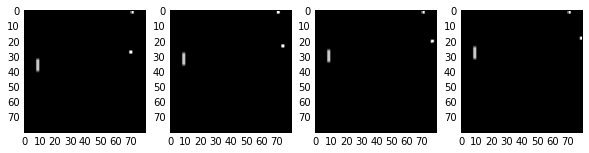

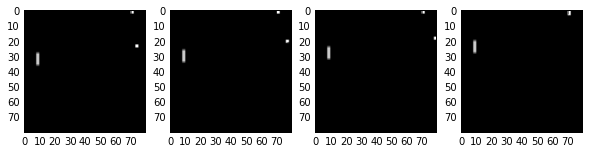

In [36]:
plot_exp(dat[70])

In [51]:
def _sample_from_experience(experience, batch_size, gamma):
    # sample from random experience from the buffer
    idxs = [i for i in range(0, len(experience))] # index into ring buffer
    np.random.shuffle(idxs)
    rand_transitions = \
        [ experience[idx] for idx in idxs[0:batch_size] ]
    print idxs[0:batch_size]
    phi_t1_minibatch = \
        img_as_float(
            np.asarray(
                [ rand_transitions[i]["phi_t1"] for i in range(len(rand_transitions)) ]
            )
        ).astype("float32")
    r_minibatch = np.asarray(
        [ [rand_transitions[i]["r_t"]] for i in range(len(rand_transitions)) ], dtype="float32")
    is_done_minibatch = np.asarray(
        [ [1.0*rand_transitions[i]["is_done"]] for i in range(len(rand_transitions)) ], dtype="float32")
    # ok, construct Q(phi_t) and its corresponding mask
    phi_t_minibatch = \
        img_as_float(
            np.asarray(
                [ rand_transitions[i]["phi_t"] for i in range(len(rand_transitions)) ]
            )
        ).astype("float32")
    mask_t_minibatch = np.zeros((phi_t_minibatch.shape[0], 6), dtype="float32")
    for i in range(mask_t_minibatch.shape[0]):
        mask_t_minibatch[ i, rand_transitions[i]["a_t"] ] = 1.

    #import pdb
    #pdb.set_trace()

    #print r_minibatch
    #print phi_t1_minibatch
    #print phi_t_minibatch
    #print mask_t_minibatch
    #print [ rand_transitions[i]["a_t"] for i in range(len(rand_transitions)) ]
    #print "----"
    #self.train_fn = theano.function([r, gamma, is_done, phi_t1, phi_t, phi_t_mask], loss, updates=updates, on_unused_input='warn')
    return r_minibatch, np.float32(gamma), is_done_minibatch, phi_t1_minibatch, phi_t_minibatch, mask_t_minibatch


In [42]:
from skimage import img_as_float

In [99]:
r_minibatch, gamma_, is_done_minibatch, phi_t1_minibatch, phi_t_minibatch, mask_t_minibatch = \
    _sample_from_experience(dat, 10, 0.95)

[980, 813, 38, 371, 398, 496, 170, 146, 189, 64]


In [100]:
r_minibatch

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-1.],
       [ 0.],
       [ 0.],
       [ 0.]], dtype=float32)

In [79]:
is_done_minibatch

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]], dtype=float32)

In [80]:
mask_t_minibatch

array([[ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

-----

In [4]:
import lasagne
import theano
import gym
from lasagne.layers import *
from lasagne.objectives import *
from lasagne.nonlinearities import *
from lasagne.updates import *
from theano import tensor as T

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: Tesla K40c (CNMeM is disabled, cuDNN 5004)


In [82]:
def dqn_paper_net(env, args={}):
    def batch_norm_or_not(layer, bn):
        if bn:
            return batch_norm(layer)
        else:
            return layer
    nonlinearity = rectify if "nonlinearity" not in args else args["nonlinearity"]
    bn = True if "batch_norm" in args else False
    #height, width, nchannels = env.observation_space.shape
    height, width = 80, 80
    nchannels = 4 # we convert to black and white and use 4 prev frames
    layer = InputLayer((None, nchannels, height, width))
    layer = batch_norm_or_not(Conv2DLayer(layer, filter_size=8, num_filters=16, stride=4, nonlinearity=nonlinearity), bn)
    layer = batch_norm_or_not(Conv2DLayer(layer, filter_size=4, num_filters=32, stride=2, nonlinearity=nonlinearity), bn)
    layer = batch_norm_or_not(DenseLayer(layer, num_units=256, nonlinearity=nonlinearity), bn)
    layer = DenseLayer(layer, num_units=env.action_space.n, nonlinearity=linear)
    return layer


In [8]:
env = gym.make('Pong-v0')
l_out = dqn_paper_net(env)

[2017-04-02 15:59:38,181] Making new env: Pong-v0


NameError: name 'dqn_paper_net' is not defined

In [104]:
# theano variables for updating Q
r = T.fmatrix('r')
is_done = T.fmatrix('is_done')
gamma = T.fscalar('gamma')
phi_t = T.tensor4('phi_t')
phi_t_mask = T.fmatrix('phi_t_mask')
phi_t1 = T.tensor4('phi_t1')
# loss
output_phi_t = get_output(l_out, phi_t)
output_phi_t1 = get_output(l_out, phi_t1)
td_target = r + (1.0-is_done)*(gamma*T.max(output_phi_t1,axis=1,keepdims=True))
td_error = (phi_t_mask*output_phi_t).sum(axis=1, keepdims=True)


In [101]:
td_target.eval({
  r: r_minibatch, is_done:is_done_minibatch, gamma:gamma_, phi_t1: phi_t1_minibatch
})

array([[ 0.1749147 ],
       [ 0.17619136],
       [ 0.18252327],
       [ 0.17567326],
       [ 0.18510683],
       [ 0.16705243],
       [-0.82733715],
       [ 0.18147129],
       [ 0.17120881],
       [ 0.1651081 ]], dtype=float32)

In [119]:
tmp = output_phi_t1.eval({phi_t1:phi_t1_minibatch})
aa = (r_minibatch + (1-is_done_minibatch)*(gamma_*np.max(tmp,axis=1,keepdims=True)))

In [109]:
td_error.eval({phi_t_mask:mask_t_minibatch, phi_t:phi_t_minibatch})

array([[ 0.1237698 ],
       [ 0.18438816],
       [-0.08566574],
       [ 0.03815587],
       [ 0.18954709],
       [ 0.03895124],
       [-0.06770211],
       [ 0.11687868],
       [ 0.0419699 ],
       [ 0.07017124]], dtype=float32)

In [120]:
tmp = output_phi_t.eval({phi_t:phi_t_minibatch})
bb = (mask_t_minibatch*tmp).sum(axis=1,keepdims=True)

In [121]:
aa

array([[ 0.1749147 ],
       [ 0.17619136],
       [ 0.18252327],
       [ 0.17567326],
       [ 0.18510683],
       [ 0.16705243],
       [-0.82733715],
       [ 0.18147129],
       [ 0.17120881],
       [ 0.1651081 ]], dtype=float32)

In [122]:
bb

array([[ 0.1237698 ],
       [ 0.18438816],
       [-0.08566574],
       [ 0.03815587],
       [ 0.18954709],
       [ 0.03895124],
       [-0.06770211],
       [ 0.11687868],
       [ 0.0419699 ],
       [ 0.07017124]], dtype=float32)

In [125]:
((aa-bb)**2).mean()

0.071688227

----------

In [129]:
l_out = dqn_paper_net(env)
for layer in get_all_layers(l_out):
    print layer, layer.output_shape

<lasagne.layers.input.InputLayer object at 0x7f71e9d4d810> (None, 4, 80, 80)
<lasagne.layers.conv.Conv2DLayer object at 0x7f71e9d4dad0> (None, 16, 19, 19)
<lasagne.layers.conv.Conv2DLayer object at 0x7f71e9d4dd10> (None, 32, 8, 8)
<lasagne.layers.dense.DenseLayer object at 0x7f71e9d5a050> (None, 256)
<lasagne.layers.dense.DenseLayer object at 0x7f71e9d5a410> (None, 6)


In [192]:
l_deconv1 = Deconv2DLayer(l_out.input_layer.input_layer, num_filters=16, filter_size=8, stride=2, crop=1)
l_deconv1.output_shape

(None, 16, 20, 20)

In [194]:
l_deconv2 = Deconv2DLayer(l_deconv1, num_filters=4, filter_size=4, stride=4)
l_deconv2.output_shape

(None, 4, 80, 80)

In [199]:
np.prod( l_deconv1.W.get_value().shape ) + np.prod( l_deconv2.W.get_value().shape )

33792

In [180]:
l_out.input_layer.input_layer.output_shape

(None, 32, 8, 8)

Define a two-armed architecture

In [19]:
def dqn_paper_net_fp(env, args={}):
    def batch_norm_or_not(layer, bn):
        if bn:
            return batch_norm(layer)
        else:
            return layer
    nonlinearity = rectify if "nonlinearity" not in args else args["nonlinearity"]
    bn = True if "batch_norm" in args else False
    #height, width, nchannels = env.observation_space.shape
    outs = {}
    height, width = 80, 80
    nchannels = 4 # we convert to black and white and use 4 prev frames
    layer = InputLayer((None, nchannels, height, width))
    layer = batch_norm_or_not(Conv2DLayer(layer, filter_size=8, num_filters=16, stride=4, nonlinearity=nonlinearity), bn)
    layer = batch_norm_or_not(Conv2DLayer(layer, filter_size=4, num_filters=32, stride=2, nonlinearity=nonlinearity), bn)
    # Q branch
    q = DenseLayer(layer, num_units=256, nonlinearity=nonlinearity)  # no bn for a reason
    q = DenseLayer(q, num_units=env.action_space.n, nonlinearity=linear)
    # future prediction
    fp = batch_norm_or_not(Deconv2DLayer(layer, num_filters=16, filter_size=8, stride=2, crop=1), bn)
    fp = batch_norm_or_not(Deconv2DLayer(fp, num_filters=4, filter_size=4, stride=4, nonlinearity=sigmoid), bn)
    return {
        "q": q,
        "fp": fp
    }


In [20]:
for layer in get_all_layers(dqn_paper_net_fp(env, {"batch_norm":True})["q"]):
    print layer, layer.output_shape

<lasagne.layers.input.InputLayer object at 0x7f7467fa9f10> (None, 4, 80, 80)
<lasagne.layers.conv.Conv2DLayer object at 0x7f7467fa9f90> (None, 16, 19, 19)
<lasagne.layers.normalization.BatchNormLayer object at 0x7f7467ff9cd0> (None, 16, 19, 19)
<lasagne.layers.special.NonlinearityLayer object at 0x7f7467fba8d0> (None, 16, 19, 19)
<lasagne.layers.conv.Conv2DLayer object at 0x7f7467a150d0> (None, 32, 8, 8)
<lasagne.layers.normalization.BatchNormLayer object at 0x7f7467a15450> (None, 32, 8, 8)
<lasagne.layers.special.NonlinearityLayer object at 0x7f7467a15910> (None, 32, 8, 8)
<lasagne.layers.dense.DenseLayer object at 0x7f7467a15ad0> (None, 256)
<lasagne.layers.dense.DenseLayer object at 0x7f7467a15cd0> (None, 6)


In [21]:
for layer in get_all_layers(dqn_paper_net_fp(env, {"batch_norm":True})["fp"]):
    print layer, layer.output_shape

<lasagne.layers.input.InputLayer object at 0x7f7467f7c750> (None, 4, 80, 80)
<lasagne.layers.conv.Conv2DLayer object at 0x7f7467fc8610> (None, 16, 19, 19)
<lasagne.layers.normalization.BatchNormLayer object at 0x7f7467f74ed0> (None, 16, 19, 19)
<lasagne.layers.special.NonlinearityLayer object at 0x7f7467a35c50> (None, 16, 19, 19)
<lasagne.layers.conv.Conv2DLayer object at 0x7f7467a35e10> (None, 32, 8, 8)
<lasagne.layers.normalization.BatchNormLayer object at 0x7f7467a35fd0> (None, 32, 8, 8)
<lasagne.layers.special.NonlinearityLayer object at 0x7f7467a1a610> (None, 32, 8, 8)
<lasagne.layers.conv.TransposedConv2DLayer object at 0x7f7467a1ad50> (None, 16, 20, 20)
<lasagne.layers.normalization.BatchNormLayer object at 0x7f7467a1f1d0> (None, 16, 20, 20)
<lasagne.layers.special.NonlinearityLayer object at 0x7f7467a1f6d0> (None, 16, 20, 20)
<lasagne.layers.conv.TransposedConv2DLayer object at 0x7f7467a1f890> (None, 4, 80, 80)
<lasagne.layers.normalization.BatchNormLayer object at 0x7f7467a1fb